In [1]:
!pip install xgboost catboost imblearn joblib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('fraud_detection.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872156 entries, 0 to 2872155
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 241.0+ MB


In [6]:
print('Number of Transactions and rows:',df.shape)

Number of Transactions and rows: (2872156, 11)


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
step,2872156.0,1.195394e+02,7.458404e+01,1.0,37.00,140.00,184.000,227.00
amount,2872155.0,1.576112e+05,2.676646e+05,0.0,12488.02,76079.62,211349.040,10000000.00
oldbalanceOrg,2872155.0,8.468535e+05,2.921141e+06,0.0,0.00,14703.00,114157.165,38939424.03
newbalanceOrig,2872155.0,8.681943e+05,2.957526e+06,0.0,0.00,0.00,153370.105,38946233.02
oldbalanceDest,2872155.0,9.938053e+05,2.299137e+06,0.0,0.00,136767.10,943505.005,42655769.20
newbalanceDest,2872155.0,1.102017e+06,2.383443e+06,0.0,0.00,223084.42,1129468.785,42655769.20
isFraud,2872155.0,8.874869e-04,2.977750e-02,0.0,0.00,0.00,0.000,1.00
isFlaggedFraud,2872155.0,3.481706e-07,5.900598e-04,0.0,0.00,0.00,0.000,1.00


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isnull().sum()

,0
step,0
type,0
amount,1
nameOrig,1
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


EXPLORATORY DATA ANALYSIS (EDA)

In [10]:
df['isFraud'].value_counts()

,count
isFraud,
0.0,2869606
1.0,2549


<Axes: xlabel='isFraud'>

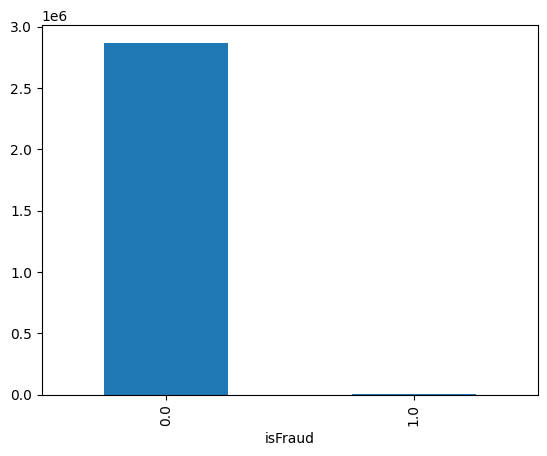

In [11]:
#Visualizing Target
df['isFraud'].value_counts().plot(kind='bar')

In [12]:
#Count of traction types
df['type'].value_counts().sort_values(ascending=False)

,count
type,
CASH_OUT,1021196
PAYMENT,965718
CASH_IN,629324
TRANSFER,237799
DEBIT,18119


<Axes: xlabel='type', ylabel='count'>

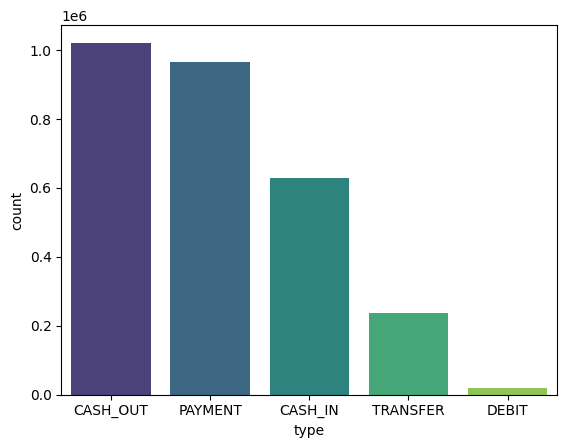

In [13]:
#Count of transactions visualization
sns.countplot(data=df,x='type',palette='viridis',order=df["type"].value_counts().index)

In [14]:
#Comparing Fraud and Not Fraud transaction types
df.groupby(['type', 'isFraud']).size().unstack()

isFraud,0.0,1.0
type,,
CASH_IN,629323.0,NaN
CASH_OUT,1019913.0,1283.0
DEBIT,18119.0,NaN
PAYMENT,965718.0,NaN
TRANSFER,236533.0,1266.0


<Axes: xlabel='type', ylabel='count'>

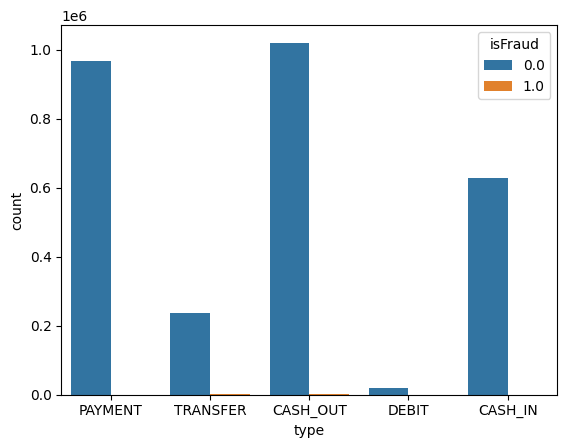

In [15]:
sns.countplot(data=df,x='type',hue='isFraud')

In [16]:
#Checking correlation in relation to isFraud
df.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)

,isFraud
isFraud,1.000000
amount,0.126757
isFlaggedFraud,0.019798
oldbalanceOrg,0.005182
newbalanceDest,0.000422
step,-0.003365
oldbalanceDest,-0.006726
newbalanceOrig,-0.008098


<Axes: >

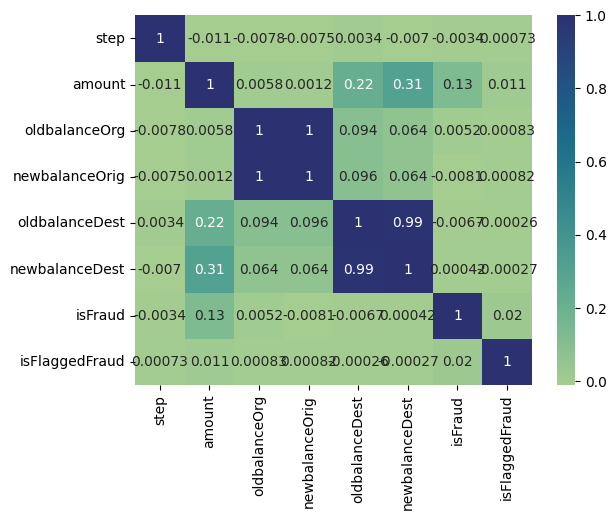

In [17]:
#Correlation Heatmap
sns.heatmap(df.corr(numeric_only=True),cmap='crest',annot=True)

DATA PREPROCESSING

In [18]:
#Get the transaction type
df['transaction_type'] = df['nameOrig'].str[0] + df['nameDest'].str[0]

In [19]:
#Get the net sender and receiver balance
df['net_sender'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['net_receiver'] = df['newbalanceDest'] - df['oldbalanceDest']

In [20]:
#Drop the columns that are no longer needed
df=df.drop(columns=['nameOrig','nameDest','isFlaggedFraud', 'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)

In [21]:
#Checking the transaction type eg CM(Customer to Merchant) etc
df['transaction_type'].unique()

array(['CM', 'CC', nan], dtype=object)

In [22]:
df['net_receiver'].unique()

array([     0.  , -21182.  ,  -1549.21, ..., -34137.2 , -64688.65,
             nan])

In [23]:
df.head()

,step,type,amount,isFraud,transaction_type,net_sender,net_receiver
0,1,PAYMENT,9839.64,0.0,CM,9839.64,0.0
1,1,PAYMENT,1864.28,0.0,CM,1864.28,0.0
2,1,TRANSFER,181.00,1.0,CC,181.00,0.0
3,1,CASH_OUT,181.00,1.0,CC,181.00,-21182.0
4,1,PAYMENT,11668.14,0.0,CM,11668.14,0.0


In [24]:
df.dropna(subset=['isFraud'], inplace=True)

In [25]:
#Handling class imbalance
fraud = df[df["isFraud"] == 1]
non_fraud = df[df["isFraud"] == 0].sample(n=60*len(fraud), random_state=42)



In [26]:
# Combine fraud and non-fraud samples
df = pd.concat([fraud, non_fraud])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
#Splitting into training and target
X = df.drop(columns=['isFraud'], axis=1)
y = df['isFraud']

In [28]:
#Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [29]:
# Catboost Classifier Model Pipeline
pipeline_cb = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('ss', StandardScaler(with_mean=False)),
    ("cb", CatBoostClassifier(verbose=0,
                              task_type='GPU',
                              early_stopping_rounds=10,
                              random_state=30,))
])

In [30]:
#Cross validation
cv =  StratifiedKFold(n_splits=2, shuffle=True, random_state=30)

In [31]:
#Catboost parameter
params_cb = {
    'cb__iterations': [100],
    'cb__learning_rate': [0.1],
    'cb__depth': [6],
    'cb__grow_policy': ['SymmetricTree'],
    'cb__loss_function': ['Logloss']
}

In [32]:
#Catboost Hyper-parameter tuning
model_cb = RandomizedSearchCV(
    pipeline_cb,
    param_distributions=params_cb,
    n_iter=1,
    scoring='recall',
    cv=cv,
    n_jobs=1,
    random_state=30,
    verbose=1
)

In [33]:
# Training the Catboost Classifier model
model_cb.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=30, shuffle=True),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(strategy='most_frequent')),
                                             ('oe',
                                              OrdinalEncoder(handle_unknown='use_encoded_value',
                                                             unknown_value=-1)),
                                             ('ss',
                                              StandardScaler(with_mean=False)),
                                             ('cb',
                                              <catboost.core.CatBoostClassifier object at 0x79f77a25cc90>)]),
                   n_iter=1, n_jobs=1,
                   param_distributions={'cb__depth': [6],
                                        'cb__grow_policy': ['SymmetricTree'],
                                        'cb__iterations': [100],
                                        'cb__learning_rate': [0.1],
                                        'cb__loss_function': ['Logloss']},
                   random_state=30, scoring='recall', verbose=1)

In [34]:
model_cb.score(X_train, y_train)

0.7778879524045612

In [35]:
y_pred_cb = model_cb.predict(X_test)

In [36]:
# Catboost Classifier model classification report
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     30566
         1.0       1.00      0.65      0.79       532

    accuracy                           0.99     31098
   macro avg       1.00      0.83      0.89     31098
weighted avg       0.99      0.99      0.99     31098



In [37]:
# Catboost Classifier model confusion matrix
print(confusion_matrix(y_test, y_pred_cb))

[[30566     0]
 [  185   347]]


In [38]:
# XGB Classifier Model Pipeline
pipeline_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('ss', StandardScaler(with_mean=False)),
    ("xgb", XGBClassifier(random_state=30))
])

In [39]:
# XGB Classifier Model Hperparamters
params_xgb = {
    'xgb__max_depth': [3, 5],
    'xgb__n_estimators': [20, 40],
    'xgb__learning_rate': [0.1],
    'xgb__tree_method': ['hist'],
    'xgb__n_jobs': [-1]
}

In [40]:
# XGB Classifier Hyperparameter tuning
model_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=params_xgb,
    n_iter=8,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    random_state=30,
    verbose=1
)

In [41]:
# Training the XGB Classifier model
model_xgb.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=30, shuffle=True),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(strategy='most_frequent')),
                                             ('oe',
                                              OrdinalEncoder(handle_unknown='use_encoded_value',
                                                             unknown_value=-1)),
                                             ('ss',
                                              StandardScaler(with_mean=False)),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_byle...
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=30, ...))]),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'xgb__learning_rate': [0.1],
                                        'xgb__max_depth': [3, 5],
                                        'xgb__n_estimators': [20, 40],
                                        'xgb__n_jobs': [-1],
                                        'xgb__tree_method': ['hist']},
                   random_state=30, scoring='recall', verbose=1)

In [42]:
model_xgb.score(X_train, y_train)

0.7674764501735251

In [43]:
y_pred_xgb = model_xgb.predict(X_test)

In [44]:
# XGB Classifier model classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     30566
         1.0       0.49      0.59      0.54       532

    accuracy                           0.98     31098
   macro avg       0.74      0.79      0.76     31098
weighted avg       0.98      0.98      0.98     31098



In [45]:
# XGB Classifier model confusion matrix
print(confusion_matrix(y_test, y_pred_xgb))

[[30233   333]
 [  216   316]]


In [46]:
# Random Forest Classifier Model Pipeline
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('ss', StandardScaler(with_mean=False)),
    ("rfc", RandomForestClassifier(random_state=30))
])

In [47]:
# Random Forest Classifier Model Hperparamters
params_rfc = {
    'rfc__max_depth': [3, 5],
    'rfc__n_estimators': [20, 40]
}

In [48]:
# Random Forest Classifier Hyperparameter tuning
model_rfc = RandomizedSearchCV(
    pipeline_rfc,
    param_distributions=params_rfc,
    n_iter=8,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    random_state=30,
    verbose=1
)

In [49]:
# Training the XGB Classifier model
model_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=30, shuffle=True),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(strategy='most_frequent')),
                                             ('oe',
                                              OrdinalEncoder(handle_unknown='use_encoded_value',
                                                             unknown_value=-1)),
                                             ('ss',
                                              StandardScaler(with_mean=False)),
                                             ('rfc',
                                              RandomForestClassifier(random_state=30))]),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'rfc__max_depth': [3, 5],
                                        'rfc__n_estimators': [20, 40]},
                   random_state=30, scoring='recall', verbose=1)

In [50]:
model_rfc.score(X_train, y_train)

0.60932077342588

In [51]:
y_pred_rfc = model_rfc.predict(X_test)

In [52]:
# Random Forrest Classifier model classification report
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     30566
         1.0       1.00      0.49      0.66       532

    accuracy                           0.99     31098
   macro avg       1.00      0.75      0.83     31098
weighted avg       0.99      0.99      0.99     31098



In [53]:
# Random Forest Classifier model confusion matrix
print(confusion_matrix(y_test, y_pred_rfc))

[[30566     0]
 [  271   261]]


In [54]:
import joblib
from google.colab import files

In [55]:
joblib.dump(model_cb, "fraud_cb.pkl")

['fraud_cb.pkl']

In [56]:
joblib.dump(model_xgb, "fraud_xgb.pkl")

['fraud_xgb.pkl']

In [57]:
files.download('fraud_cb.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
files.download('fraud_xgb.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155489 entries, 0 to 155488
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              155489 non-null  int64  
 1   type              155489 non-null  object 
 2   amount            155489 non-null  float64
 3   isFraud           155489 non-null  float64
 4   transaction_type  155489 non-null  object 
 5   net_sender        155489 non-null  float64
 6   net_receiver      155489 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 8.3+ MB
